## Criando uma classe agente

In [1]:
import gymnasium as gym
from torch import nn
import torch
import numpy as np
from tqdm import tqdm
from models import AgentQLearning, AgentSarsa, AgentBase, NeuralNetwork, AgentDQN

# 1. Criar o ambiente
env_name = "MountainCar-v0"
env = gym.make(env_name)

(state,_) = env.reset()

print('State space: ', env.observation_space)
print('Action space: ', env.action_space)

print(env.observation_space.low)
print(env.observation_space.high)

State space:  Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Action space:  Discrete(3)
[-1.2  -0.07]
[0.6  0.07]


In [21]:
def train(alpha, 
          gamma, 
          epsilon, 
          epsilon_min, 
          epsilon_decay, 
          episodes=500,
          verbose=False,
          algorithm='qlearning',
          save=False,
          path=None,
          window=25,
          env=None):
    
    if algorithm == 'qlearning':
        agent = AgentQLearning(env=env,
                    alpha=alpha, 
                    gamma=gamma, 
                    epsilon=epsilon, 
                    epsilon_min=epsilon_min, 
                    epsilon_decay=epsilon_decay)
    elif algorithm == 'sarsa':
        agent = AgentSarsa(env=env,
                    alpha=alpha, 
                    gamma=gamma, 
                    epsilon=epsilon, 
                    epsilon_min=epsilon_min, 
                    epsilon_decay=epsilon_decay)
    elif algorithm == 'deepqlearning':
        action_size = env.action_space.n
        observation_size = env.observation_space.shape[0]
        fc1_dim = 512
        fc2_dim = 512  
        agent = AgentDQN(action_size=action_size,
              observation_size=observation_size,
              fc1_dim=fc1_dim,
              fc2_dim=fc2_dim,
              lr=4e-4,
              gamma=gamma,
              epsilon=epsilon,      
              epsilon_min=epsilon_min, 
              epsilon_decay=epsilon_decay,
              batch_size=64,
              device='cuda',
              env=env)
    
    total_rewards = []
    mean_rewards = []
    if algorithm != 'deepqlearning':
        for episode in tqdm(range(episodes),
                            disable=not verbose):
            state, _ = env.reset()
            done = False
            total_reward = 0
            step = 0
            while not done:
                action = agent.get_action(state)
                next_state, reward, terminated, truncated, _ = env.step(action)
                
                done = terminated or (step >= 1_200)
                agent.learn(state, action, reward, next_state)
                total_reward += reward
                state = next_state
                step += 1
                # print(action)
                
            agent.update_epsilon()
            total_rewards.append(total_reward)
            
            if window:
                if (episode+1) % window == 0:
                    mean_reward = np.mean(total_rewards[-window:])
                    mean_rewards.append(mean_reward)
                    if verbose and (episode+1) % 100 == 0:
                        print(f"Episode {episode + 1}: {mean_reward}")
    else:
        score_history = []
        avg_score_history = []
        for episode in tqdm(range(episodes),
                            disable=not verbose):
            obs = env.reset()[0]
            episode_over = False
            score = 0
            step = 0
            while not episode_over:
                obs = torch.tensor(obs)
                action = agent.get_action(obs)
                next_obs, reward, terminated, truncated, info = env.step(action)
                episode_over = terminated or (step >= 1_200)
                agent.store_transition(obs, action, reward, next_obs, episode_over)
                agent.learn()
                next_obs = torch.tensor(next_obs)
                score += reward
                obs = next_obs
                step += 1
                
            score_history.append(score)
            
            if window:
                if episode % window == 0:
                    avg_score = np.mean(score_history[-window:])
                    avg_score_history.append(avg_score)
                    print('episode: ', episode,'score: %.1f' % score,
                        'average score %.1f' % avg_score)
        mean_rewards = avg_score_history
                
    if save:
        if algorithm == 'qlearning':
            if path is None:
                path = f"./saved_models/model_{algorithm}_{env.env.env.spec.name}.npy"
            agent.save(path)
        if algorithm == 'deepqlearning':
            if path is None:
                path = f"./saved_models/model_{algorithm}_{env.env.env.spec.name}.pth"
            policy = agent.policy
            torch.save(policy.state_dict(), path)
    
    return mean_rewards

In [ ]:
action_size = env.action_space.n
observation_size = env.observation_space.shape[0]
fc1_dim = 512
fc2_dim = 512  

agent = AgentDQN(action_size=0,
              observation_size=0,
              fc1_dim=fc1_dim,
              fc2_dim=fc2_dim,
              lr=4e-4,
              gamma=0.99,
              epsilon=1.0,      
              epsilon_min=0.01, 
              epsilon_decay=0.999,
              batch_size=64,
              device='cuda',
              env=env)

policy = agent.policy
torch.save(policy.state_dict(), 'policy.pth')

[19 15]


c:\Users\gabri\anaconda3\envs\rl\lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


### Variando algoritmos

In [26]:
episodes_default = 750

alpha_default = 0.1 # variar de 0.1 a 0.9 com 10 pontos
gamma_default = 0.99
epsilon_default = 1.0
epsilon_min_default = 0.01 # variar de 0.001 a 0.4 com 10 pontos
epsilon_decay_default = 0.999


# alpha_default = 0.4 # variar de 0.1 a 0.9 com 10 pontos
# gamma_default = 0.99
# epsilon_default = 1.0
# epsilon_min_default = 0.01 # variar de 0.001 a 0.4 com 10 pontos
# epsilon_decay_default = 0.999

# alpha_default = 0.9 # variar de 0.1 a 0.9 com 10 pontos
# gamma_default = 0.9
# epsilon_default = 1.0
# epsilon_min_default = 0.001 # variar de 0.001 a 0.4 com 10 pontos
# epsilon_decay_default = 2 / episodes_default


n_batches = 5
n_episodes = episodes_default
window = 25

results_alg = {}
for algorithm in ['qlearning', 'deepqlearning']:
    print(f"Training with algorithm = {algorithm}")
    rewards_alg = []
    save = False
    for _ in range(n_batches):
        if _ == n_batches - 1:
            save = True
        rewards_alg.append(train(alpha=alpha_default, 
                                 gamma=gamma_default, 
                                 epsilon=epsilon_default, 
                                 epsilon_min=epsilon_min_default, 
                                 epsilon_decay=epsilon_decay_default, 
                                 episodes=n_episodes,
                                 algorithm=algorithm,
                                 save=save,
                                 verbose=True,
                                 window=window,
                                 env=env))
    rewards_alg_mean = np.mean(rewards_alg, axis=0)
    rewards_alg_std = np.std(rewards_alg, axis=0)

    print(f"Mean reward: {rewards_alg_mean[-1]}")
    print(f"Std reward: {rewards_alg_std[-1]}")
    print("-----------------------------------")
    results_alg[algorithm] = (rewards_alg_mean, rewards_alg_std)

Training with algorithm = qlearning


 14%|█▎        | 103/750 [00:05<00:32, 19.75it/s]

Episode 100: -1200.12


 27%|██▋       | 204/750 [00:10<00:25, 21.16it/s]

Episode 200: -1088.48


 41%|████      | 305/750 [00:14<00:20, 21.91it/s]

Episode 300: -1005.32


 54%|█████▍    | 406/750 [00:18<00:10, 31.35it/s]

Episode 400: -708.12


 67%|██████▋   | 506/750 [00:20<00:05, 41.77it/s]

Episode 500: -515.32


 81%|████████  | 607/750 [00:23<00:03, 38.94it/s]

Episode 600: -572.68


 94%|█████████▍| 708/750 [00:25<00:00, 48.45it/s]

Episode 700: -521.36


 14%|█▎        | 103/750 [00:05<00:33, 19.58it/s]

Episode 100: -1201.0


 27%|██▋       | 203/750 [00:10<00:29, 18.34it/s]

Episode 200: -1155.52


 41%|████      | 304/750 [00:14<00:19, 22.76it/s]

Episode 300: -970.6


 54%|█████▍    | 407/750 [00:18<00:12, 28.27it/s]

Episode 400: -627.24


 67%|██████▋   | 504/750 [00:21<00:08, 30.51it/s]

Episode 500: -626.64


 81%|████████  | 608/750 [00:23<00:02, 54.40it/s]

Episode 600: -431.12


 96%|█████████▌| 720/750 [00:25<00:00, 57.20it/s]

Episode 700: -332.36


 14%|█▍        | 106/750 [00:05<00:33, 19.44it/s]

Episode 100: -1185.92


 27%|██▋       | 204/750 [00:10<00:26, 20.23it/s]

Episode 200: -1158.44


 41%|████      | 305/750 [00:14<00:14, 30.53it/s]

Episode 300: -832.6


 54%|█████▍    | 404/750 [00:18<00:11, 30.08it/s]

Episode 400: -740.84


 68%|██████▊   | 507/750 [00:21<00:06, 37.39it/s]

Episode 500: -645.04


 81%|████████  | 607/750 [00:24<00:04, 33.47it/s]

Episode 600: -626.2


 94%|█████████▍| 705/750 [00:26<00:00, 50.33it/s]

Episode 700: -435.28


 14%|█▍        | 105/750 [00:05<00:30, 21.09it/s]

Episode 100: -1185.64


 27%|██▋       | 204/750 [00:09<00:26, 20.66it/s]

Episode 200: -1157.28


 41%|████      | 306/750 [00:14<00:16, 27.01it/s]

Episode 300: -896.08


 54%|█████▍    | 406/750 [00:17<00:12, 28.17it/s]

Episode 400: -725.68


 67%|██████▋   | 505/750 [00:20<00:06, 38.73it/s]

Episode 500: -578.44


 81%|████████▏ | 611/750 [00:23<00:02, 49.04it/s]

Episode 600: -528.36


 94%|█████████▍| 708/750 [00:25<00:00, 55.32it/s]

Episode 700: -421.96


 14%|█▎        | 103/750 [00:05<00:31, 20.82it/s]

Episode 100: -1201.0


 27%|██▋       | 202/750 [00:09<00:23, 23.49it/s]

Episode 200: -1092.36


 41%|████      | 304/750 [00:14<00:19, 23.16it/s]

Episode 300: -1069.64


 55%|█████▍    | 409/750 [00:17<00:08, 40.93it/s]

Episode 400: -560.64


 68%|██████▊   | 508/750 [00:20<00:05, 44.37it/s]

Episode 500: -509.4


 81%|████████▏ | 611/750 [00:23<00:03, 44.91it/s]

Episode 600: -568.16


 95%|█████████▍| 709/750 [00:25<00:00, 50.59it/s]

Episode 700: -471.0


100%|██████████| 750/750 [00:26<00:00, 28.80it/s]


Q-table salva em ./saved_models/model_qlearning_MountainCar.npy
Mean reward: -442.14400000000006
Std reward: 91.39569740419951
-----------------------------------
Training with algorithm = deepqlearning
[19 15]


  0%|          | 0/750 [00:00<?, ?it/s]C:\Users\gabri\AppData\Local\Temp\ipykernel_35820\748808526.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  obs = torch.tensor(obs)
  0%|          | 1/750 [00:03<47:54,  3.84s/it]

episode:  0 score: -1201.0 average score -1201.0


  3%|▎         | 26/750 [01:48<50:17,  4.17s/it]

episode:  25 score: -1201.0 average score -1201.0


  7%|▋         | 51/750 [02:41<08:41,  1.34it/s]

episode:  50 score: -223.0 average score -616.6


 10%|█         | 76/750 [02:53<05:14,  2.14it/s]

episode:  75 score: -139.0 average score -140.6


 13%|█▎        | 101/750 [03:04<04:44,  2.28it/s]

episode:  100 score: -143.0 average score -132.9


 17%|█▋        | 126/750 [03:16<04:34,  2.27it/s]

episode:  125 score: -95.0 average score -136.5


 20%|██        | 151/750 [03:28<04:34,  2.18it/s]

episode:  150 score: -155.0 average score -135.6


 23%|██▎       | 176/750 [03:39<03:49,  2.50it/s]

episode:  175 score: -109.0 average score -126.7


 27%|██▋       | 201/750 [03:50<04:31,  2.02it/s]

episode:  200 score: -147.0 average score -130.7


 30%|███       | 226/750 [04:02<03:34,  2.44it/s]

episode:  225 score: -90.0 average score -129.8


 33%|███▎      | 251/750 [04:13<04:00,  2.08it/s]

episode:  250 score: -147.0 average score -130.8


 37%|███▋      | 276/750 [04:24<04:07,  1.92it/s]

episode:  275 score: -162.0 average score -120.0


 40%|████      | 301/750 [04:37<03:17,  2.27it/s]

episode:  300 score: -107.0 average score -142.6


 43%|████▎     | 326/750 [04:48<03:07,  2.26it/s]

episode:  325 score: -91.0 average score -128.8


 47%|████▋     | 351/750 [04:59<02:40,  2.49it/s]

episode:  350 score: -108.0 average score -117.7


 50%|█████     | 376/750 [05:10<03:13,  1.93it/s]

episode:  375 score: -150.0 average score -122.3


 53%|█████▎    | 401/750 [05:21<02:12,  2.64it/s]

episode:  400 score: -92.0 average score -118.5


 57%|█████▋    | 426/750 [05:31<02:20,  2.30it/s]

episode:  425 score: -123.0 average score -119.5


 60%|██████    | 451/750 [05:41<02:09,  2.30it/s]

episode:  450 score: -139.0 average score -116.4


 63%|██████▎   | 476/750 [05:51<01:36,  2.84it/s]

episode:  475 score: -106.0 average score -103.8


 67%|██████▋   | 501/750 [06:01<01:44,  2.38it/s]

episode:  500 score: -112.0 average score -117.9


 70%|███████   | 526/750 [06:17<02:08,  1.75it/s]

episode:  525 score: -95.0 average score -125.6


 73%|███████▎  | 551/750 [06:32<02:17,  1.45it/s]

episode:  550 score: -180.0 average score -120.8


 77%|███████▋  | 576/750 [06:48<01:36,  1.79it/s]

episode:  575 score: -118.0 average score -129.4


 80%|████████  | 601/750 [07:04<01:34,  1.58it/s]

episode:  600 score: -119.0 average score -121.0


 83%|████████▎ | 626/750 [07:17<01:03,  1.97it/s]

episode:  625 score: -108.0 average score -110.2


 87%|████████▋ | 651/750 [07:31<00:45,  2.17it/s]

episode:  650 score: -104.0 average score -107.8


 90%|█████████ | 676/750 [07:45<00:54,  1.36it/s]

episode:  675 score: -165.0 average score -114.0


 93%|█████████▎| 701/750 [08:00<00:31,  1.58it/s]

episode:  700 score: -87.0 average score -119.6


 97%|█████████▋| 726/750 [08:16<00:13,  1.78it/s]

episode:  725 score: -107.0 average score -133.2


100%|██████████| 750/750 [08:32<00:00,  1.46it/s]


[19 15]


  0%|          | 1/750 [00:04<1:01:18,  4.91s/it]

episode:  0 score: -1201.0 average score -1201.0


  3%|▎         | 26/750 [01:58<30:47,  2.55s/it]  

episode:  25 score: -285.0 average score -925.4


  7%|▋         | 51/750 [02:22<09:23,  1.24it/s]

episode:  50 score: -180.0 average score -176.3


 10%|█         | 76/750 [02:39<07:13,  1.55it/s]

episode:  75 score: -101.0 average score -130.8


 13%|█▎        | 101/750 [02:55<07:33,  1.43it/s]

episode:  100 score: -116.0 average score -125.7


 17%|█▋        | 126/750 [03:14<07:26,  1.40it/s]

episode:  125 score: -118.0 average score -147.5


 20%|██        | 151/750 [03:32<06:00,  1.66it/s]

episode:  150 score: -180.0 average score -151.5


 23%|██▎       | 176/750 [03:52<06:58,  1.37it/s]

episode:  175 score: -149.0 average score -145.9


 27%|██▋       | 201/750 [04:11<06:48,  1.34it/s]

episode:  200 score: -135.0 average score -146.1


 30%|███       | 226/750 [04:28<06:08,  1.42it/s]

episode:  225 score: -184.0 average score -140.1


 33%|███▎      | 251/750 [04:44<04:56,  1.68it/s]

episode:  250 score: -106.0 average score -128.5


 37%|███▋      | 276/750 [05:02<04:37,  1.71it/s]

episode:  275 score: -93.0 average score -132.9


 40%|████      | 301/750 [05:19<05:22,  1.39it/s]

episode:  300 score: -99.0 average score -132.0


 43%|████▎     | 326/750 [05:35<04:14,  1.66it/s]

episode:  325 score: -154.0 average score -125.9


 47%|████▋     | 351/750 [05:52<03:55,  1.69it/s]

episode:  350 score: -109.0 average score -126.6


 50%|█████     | 376/750 [06:08<03:31,  1.77it/s]

episode:  375 score: -99.0 average score -125.5


 53%|█████▎    | 401/750 [06:25<03:22,  1.72it/s]

episode:  400 score: -98.0 average score -131.2


 57%|█████▋    | 426/750 [06:41<03:48,  1.42it/s]

episode:  425 score: -117.0 average score -133.4


 60%|██████    | 451/750 [06:58<03:18,  1.51it/s]

episode:  450 score: -156.0 average score -127.1


 63%|██████▎   | 476/750 [07:13<02:35,  1.76it/s]

episode:  475 score: -144.0 average score -117.5


 67%|██████▋   | 501/750 [07:28<02:27,  1.69it/s]

episode:  500 score: -127.0 average score -128.8


 70%|███████   | 526/750 [07:44<02:01,  1.84it/s]

episode:  525 score: -112.0 average score -113.0


 73%|███████▎  | 551/750 [08:00<02:46,  1.19it/s]

episode:  550 score: -175.0 average score -129.8


 77%|███████▋  | 576/750 [08:15<01:45,  1.65it/s]

episode:  575 score: -115.0 average score -114.4


 80%|████████  | 601/750 [08:31<01:41,  1.47it/s]

episode:  600 score: -123.0 average score -121.1


 83%|████████▎ | 626/750 [08:46<01:01,  2.01it/s]

episode:  625 score: -87.0 average score -113.8


 87%|████████▋ | 651/750 [09:00<00:53,  1.85it/s]

episode:  650 score: -111.0 average score -113.0


 90%|█████████ | 676/750 [09:14<00:42,  1.75it/s]

episode:  675 score: -86.0 average score -108.1


 93%|█████████▎| 701/750 [09:31<00:26,  1.83it/s]

episode:  700 score: -108.0 average score -121.9


 97%|█████████▋| 726/750 [09:44<00:12,  1.95it/s]

episode:  725 score: -103.0 average score -109.1


100%|██████████| 750/750 [10:00<00:00,  1.25it/s]


[19 15]


  0%|          | 1/750 [00:04<1:02:21,  4.99s/it]

episode:  0 score: -1201.0 average score -1201.0


  3%|▎         | 26/750 [02:35<1:11:38,  5.94s/it]

episode:  25 score: -1201.0 average score -1201.0


  7%|▋         | 51/750 [03:26<14:53,  1.28s/it]  

episode:  50 score: -131.0 average score -390.3


 10%|█         | 76/750 [03:45<07:57,  1.41it/s]

episode:  75 score: -195.0 average score -146.4


 13%|█▎        | 101/750 [04:00<06:29,  1.66it/s]

episode:  100 score: -112.0 average score -120.9


 17%|█▋        | 126/750 [04:16<07:31,  1.38it/s]

episode:  125 score: -115.0 average score -121.4


 20%|██        | 151/750 [04:32<06:40,  1.49it/s]

episode:  150 score: -159.0 average score -121.8


 23%|██▎       | 176/750 [04:48<07:29,  1.28it/s]

episode:  175 score: -165.0 average score -130.3


 27%|██▋       | 201/750 [05:05<07:31,  1.22it/s]

episode:  200 score: -160.0 average score -126.7


 30%|███       | 226/750 [05:20<05:08,  1.70it/s]

episode:  225 score: -123.0 average score -118.8


 33%|███▎      | 251/750 [05:37<04:31,  1.84it/s]

episode:  250 score: -96.0 average score -127.2


 37%|███▋      | 276/750 [05:53<05:58,  1.32it/s]

episode:  275 score: -137.0 average score -125.2


 40%|████      | 301/750 [06:09<04:29,  1.67it/s]

episode:  300 score: -156.0 average score -124.9


 43%|████▎     | 326/750 [06:24<03:42,  1.90it/s]

episode:  325 score: -107.0 average score -118.7


 47%|████▋     | 351/750 [06:39<03:37,  1.84it/s]

episode:  350 score: -115.0 average score -121.1


 50%|█████     | 376/750 [06:55<04:22,  1.42it/s]

episode:  375 score: -179.0 average score -115.2


 53%|█████▎    | 401/750 [07:12<04:15,  1.37it/s]

episode:  400 score: -160.0 average score -129.9


 57%|█████▋    | 426/750 [07:27<03:34,  1.51it/s]

episode:  425 score: -124.0 average score -123.8


 60%|██████    | 451/750 [07:44<02:36,  1.91it/s]

episode:  450 score: -88.0 average score -119.4


 63%|██████▎   | 476/750 [07:58<02:17,  1.99it/s]

episode:  475 score: -85.0 average score -118.9


 67%|██████▋   | 501/750 [08:11<02:01,  2.05it/s]

episode:  500 score: -107.0 average score -104.1


 70%|███████   | 526/750 [08:27<02:58,  1.25it/s]

episode:  525 score: -118.0 average score -123.0


 73%|███████▎  | 551/750 [08:46<02:07,  1.56it/s]

episode:  550 score: -89.0 average score -143.0


 77%|███████▋  | 576/750 [09:01<02:06,  1.38it/s]

episode:  575 score: -140.0 average score -120.9


 80%|████████  | 601/750 [09:16<01:35,  1.57it/s]

episode:  600 score: -92.0 average score -120.0


 83%|████████▎ | 626/750 [09:30<01:14,  1.67it/s]

episode:  625 score: -122.0 average score -114.1


 87%|████████▋ | 651/750 [09:44<00:57,  1.73it/s]

episode:  650 score: -107.0 average score -113.3


 90%|█████████ | 676/750 [10:00<00:49,  1.48it/s]

episode:  675 score: -89.0 average score -113.4


 93%|█████████▎| 701/750 [10:17<00:41,  1.19it/s]

episode:  700 score: -171.0 average score -128.6


 97%|█████████▋| 726/750 [10:32<00:13,  1.79it/s]

episode:  725 score: -126.0 average score -123.3


100%|██████████| 750/750 [10:47<00:00,  1.16it/s]


[19 15]


  0%|          | 1/750 [00:05<1:11:54,  5.76s/it]

episode:  0 score: -1201.0 average score -1201.0


  3%|▎         | 26/750 [01:03<16:11,  1.34s/it] 

episode:  25 score: -262.0 average score -453.8


  7%|▋         | 51/750 [01:24<07:57,  1.46it/s]

episode:  50 score: -145.0 average score -166.5


 10%|█         | 76/750 [01:43<07:48,  1.44it/s]

episode:  75 score: -106.0 average score -154.1


 13%|█▎        | 101/750 [02:05<08:34,  1.26it/s]

episode:  100 score: -150.0 average score -163.5


 17%|█▋        | 126/750 [02:24<07:10,  1.45it/s]

episode:  125 score: -164.0 average score -158.6


 20%|██        | 151/750 [02:44<08:16,  1.21it/s]

episode:  150 score: -133.0 average score -142.9


 23%|██▎       | 176/750 [03:00<07:01,  1.36it/s]

episode:  175 score: -138.0 average score -134.0


 27%|██▋       | 201/750 [03:17<05:56,  1.54it/s]

episode:  200 score: -149.0 average score -129.3


 30%|███       | 226/750 [03:36<08:25,  1.04it/s]

episode:  225 score: -190.0 average score -141.7


 33%|███▎      | 251/750 [03:54<05:48,  1.43it/s]

episode:  250 score: -156.0 average score -144.6


 37%|███▋      | 276/750 [04:11<07:27,  1.06it/s]

episode:  275 score: -252.0 average score -135.6


 40%|████      | 301/750 [04:30<04:54,  1.52it/s]

episode:  300 score: -152.0 average score -134.6


 43%|████▎     | 326/750 [04:48<05:56,  1.19it/s]

episode:  325 score: -188.0 average score -140.0


 47%|████▋     | 351/750 [05:03<04:11,  1.59it/s]

episode:  350 score: -109.0 average score -117.0


 50%|█████     | 376/750 [05:20<03:24,  1.83it/s]

episode:  375 score: -109.0 average score -117.6


 53%|█████▎    | 401/750 [05:35<03:02,  1.91it/s]

episode:  400 score: -84.0 average score -120.6


 57%|█████▋    | 426/750 [05:50<02:52,  1.88it/s]

episode:  425 score: -90.0 average score -114.7


 60%|██████    | 451/750 [06:07<03:15,  1.53it/s]

episode:  450 score: -108.0 average score -122.8


 63%|██████▎   | 476/750 [06:24<03:10,  1.44it/s]

episode:  475 score: -152.0 average score -135.6


 67%|██████▋   | 501/750 [06:40<02:29,  1.66it/s]

episode:  500 score: -132.0 average score -125.3


 70%|███████   | 526/750 [06:57<02:24,  1.55it/s]

episode:  525 score: -143.0 average score -116.9


 73%|███████▎  | 551/750 [07:11<01:43,  1.93it/s]

episode:  550 score: -97.0 average score -107.0


 77%|███████▋  | 576/750 [07:24<01:44,  1.67it/s]

episode:  575 score: -105.0 average score -108.4


 80%|████████  | 601/750 [07:42<02:43,  1.10s/it]

episode:  600 score: -211.0 average score -130.2


 83%|████████▎ | 626/750 [07:59<01:13,  1.68it/s]

episode:  625 score: -106.0 average score -130.2


 87%|████████▋ | 651/750 [08:14<00:55,  1.78it/s]

episode:  650 score: -111.0 average score -119.8


 90%|█████████ | 676/750 [08:29<00:48,  1.52it/s]

episode:  675 score: -111.0 average score -105.6


 93%|█████████▎| 701/750 [08:45<00:28,  1.70it/s]

episode:  700 score: -109.0 average score -119.6


 97%|█████████▋| 726/750 [08:58<00:13,  1.83it/s]

episode:  725 score: -114.0 average score -104.7


100%|██████████| 750/750 [09:15<00:00,  1.35it/s]


[19 15]


  0%|          | 1/750 [00:06<1:15:31,  6.05s/it]

episode:  0 score: -1201.0 average score -1201.0


  3%|▎         | 26/750 [02:41<1:18:25,  6.50s/it]

episode:  25 score: -1201.0 average score -1201.0


  7%|▋         | 51/750 [03:31<11:16,  1.03it/s]  

episode:  50 score: -186.0 average score -389.2


 10%|█         | 76/750 [03:50<07:30,  1.50it/s]

episode:  75 score: -173.0 average score -143.4


 13%|█▎        | 101/750 [04:07<06:38,  1.63it/s]

episode:  100 score: -111.0 average score -124.4


 17%|█▋        | 126/750 [04:21<06:48,  1.53it/s]

episode:  125 score: -172.0 average score -116.4


 20%|██        | 151/750 [04:38<06:48,  1.47it/s]

episode:  150 score: -107.0 average score -125.4


 23%|██▎       | 176/750 [04:55<09:13,  1.04it/s]

episode:  175 score: -143.0 average score -129.7


 27%|██▋       | 201/750 [05:12<05:31,  1.66it/s]

episode:  200 score: -95.0 average score -128.8


 30%|███       | 226/750 [05:27<04:55,  1.77it/s]

episode:  225 score: -105.0 average score -109.8


 33%|███▎      | 251/750 [05:41<04:49,  1.72it/s]

episode:  250 score: -105.0 average score -103.5


 37%|███▋      | 276/750 [05:58<05:08,  1.54it/s]

episode:  275 score: -121.0 average score -119.6


 40%|████      | 301/750 [06:16<05:53,  1.27it/s]

episode:  300 score: -146.0 average score -143.2


 43%|████▎     | 326/750 [06:33<04:24,  1.60it/s]

episode:  325 score: -125.0 average score -129.6


 47%|████▋     | 351/750 [06:48<03:21,  1.98it/s]

episode:  350 score: -90.0 average score -120.4


 50%|█████     | 376/750 [07:03<03:45,  1.66it/s]

episode:  375 score: -105.0 average score -114.4


 53%|█████▎    | 401/750 [07:19<03:43,  1.56it/s]

episode:  400 score: -110.0 average score -112.2


 57%|█████▋    | 426/750 [07:33<03:05,  1.74it/s]

episode:  425 score: -108.0 average score -110.1


 60%|██████    | 451/750 [07:48<03:19,  1.50it/s]

episode:  450 score: -141.0 average score -120.2


 63%|██████▎   | 476/750 [08:03<03:19,  1.37it/s]

episode:  475 score: -120.0 average score -111.5


 67%|██████▋   | 501/750 [08:19<02:24,  1.72it/s]

episode:  500 score: -123.0 average score -119.7


 70%|███████   | 526/750 [08:34<02:18,  1.62it/s]

episode:  525 score: -115.0 average score -115.2


 73%|███████▎  | 551/750 [08:51<02:03,  1.61it/s]

episode:  550 score: -130.0 average score -127.8


 77%|███████▋  | 576/750 [09:06<01:32,  1.87it/s]

episode:  575 score: -94.0 average score -114.9


 80%|████████  | 601/750 [09:20<01:26,  1.73it/s]

episode:  600 score: -99.0 average score -109.0


 83%|████████▎ | 626/750 [09:35<01:10,  1.77it/s]

episode:  625 score: -91.0 average score -102.8


 87%|████████▋ | 651/750 [09:49<00:56,  1.76it/s]

episode:  650 score: -96.0 average score -110.2


 90%|█████████ | 676/750 [10:04<00:44,  1.65it/s]

episode:  675 score: -155.0 average score -119.4


 93%|█████████▎| 701/750 [10:21<00:37,  1.31it/s]

episode:  700 score: -125.0 average score -114.0


 97%|█████████▋| 726/750 [10:36<00:14,  1.66it/s]

episode:  725 score: -134.0 average score -117.7


100%|██████████| 750/750 [10:50<00:00,  1.15it/s]

Mean reward: -117.60800000000002
Std reward: 10.125718542404778
-----------------------------------


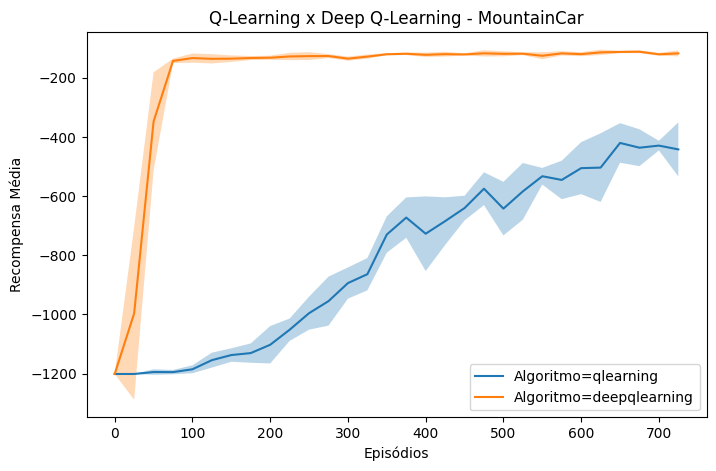

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

# Criar figura
plt.figure(figsize=(8, 5))

for alg in ['qlearning', 'deepqlearning']:#, 'sarsa']:
    rewards_alg_mean, rewards_alg_std = results_alg[alg]
    rewards_alg_mean = rewards_alg_mean
    rewards_alg_std = rewards_alg_std
    x_values = np.array(range(len(rewards_alg_mean))) * window
    sns.lineplot(x=x_values, y=rewards_alg_mean, label="Algoritmo=" + str(alg))
    plt.fill_between(x_values, rewards_alg_mean - rewards_alg_std, rewards_alg_mean + rewards_alg_std, alpha=0.3)

# Configurações
plt.xlabel("Episódios")
plt.ylabel("Recompensa Média")
plt.title(r"Q-Learning x Deep Q-Learning - " + f"{env.env.env.spec.name}")
plt.legend()
plt.show()

## Definição de meta

Para o contexto atual de testes, vamos definir nossa meta em -200 pontos. Ou seja, o agente deve ser capaz de atingir uma recompensa média de -200 pontos.

## Conclusão parcial (Deep Q-Learning)

Para o deep q learning, podemos visualizar que o gráfico de recompensa converge para valores satisfatórios. Além disso, vale comentar também que o tempo de treinamento foi relativamente baixo, se comparado com outros algoritmos (no caso presente, o Q-Learning).

## Hiper-parâmetros

Para o deep q learning, os hiper-parâmetros foram os seguintes:

$\alpha = 4-e4$

$\gamma = 0.99$

$\epsilon = 1.0$

$\epsilon_{min} = 0.01$

$\epsilon_{decay} = 0.999$

## Conclusão parcial (Q-Learning)

Para o q learning, podemos visualizar que o gráfico de recompensa tende a estabilizar em um patamar próximo de 200 (que é a meta), porém, ainda não alcança o valor ideal da meta para um tempo de 750 episódios. Além disso, vale comentar também que o tempo de treinamento foi relativamente alto, se comparado com o algoritmo Deep Q Learning.

## Hiper-parâmetros

Para o q learning, os hiper-parâmetros foram os seguintes:

$\alpha = 0.1$

$\gamma = 0.99$

$\epsilon = 1.0$

$\epsilon_{min} = 0.01$

$\epsilon_{decay} = 0.999$

## Inferência

In [36]:
# 1. Criar o ambiente
env = gym.make(env_name)#, render_mode='human')

# Load Q table Q-Learning
agent_loaded_qlearning = AgentBase(env=env)
agent_loaded_qlearning.load("./saved_models/model_qlearning_MountainCar.npy")

n_batches = 5

all_rewards_qlearning = []
num_episodes = 100

for idx in tqdm(range(n_batches)):
    reward_qlearning = []
    for i in tqdm(range(num_episodes)):
        state, _ = env.reset()
        done = False
        score = 0
        
        while not done:
            state_ = agent_loaded_qlearning.transform_state(state)
            action = np.argmax(agent_loaded_qlearning.Q[state_[0], state_[1]])
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            score += reward
            state = next_state
        # print(score)
            
        reward_qlearning.append(score)
    
    all_rewards_qlearning.append(reward_qlearning)
    env.close()

Q-table carregada de ./saved_models/model_qlearning_MountainCar.npy


100%|██████████| 5/5 [00:02<00:00,  2.30it/s]


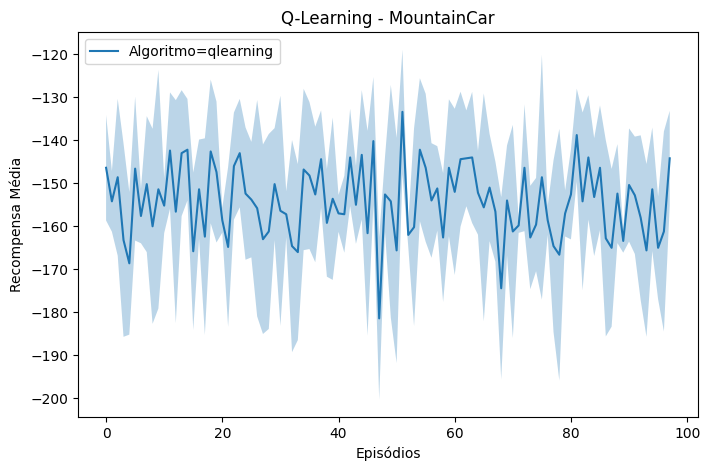

In [38]:
# Criar figura
plt.figure(figsize=(8, 5))

results_alg = {
    'qlearning': (np.mean(all_rewards_qlearning, axis=0), np.std(all_rewards_qlearning, axis=0))
}

for alg in ['qlearning']:#, 'sarsa']:
    rewards_alg_mean, rewards_alg_std = results_alg[alg]
    rewards_alg_mean = rewards_alg_mean[2:]
    rewards_alg_std = rewards_alg_std[2:]
    x_values = np.array(range(len(rewards_alg_mean))) 
    sns.lineplot(x=x_values, y=rewards_alg_mean, label="Algoritmo=" + str(alg))
    plt.fill_between(x_values, rewards_alg_mean - rewards_alg_std, rewards_alg_mean + rewards_alg_std, alpha=0.3)

# Configurações
plt.xlabel("Episódios")
plt.ylabel("Recompensa Média")
plt.title(r"Q-Learning - " + f"{env.env.env.spec.name}")
plt.legend()
plt.show()

In [50]:
size_r = 10
size_v = 100

n_states = (env.observation_space.high - env.observation_space.low)*np.array([size_r, size_v])
n_states = np.round(n_states, 0).astype(int) + 1
fc1_dim = 512
fc2_dim = 512
action_size = env.action_space.n
policy = NeuralNetwork(fc1_dim=fc1_dim,
                        fc2_dim=fc2_dim,
                        input_dim=len(n_states),
                        output_dim=action_size).to('cuda')

policy.load_state_dict(torch.load('./saved_models/model_deepqlearning_MountainCar.pth'))
policy.eval()  # Coloca o modelo em modo de avaliação (sem dropout, etc.)

NeuralNetwork(
  (fc1): Linear(in_features=2, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (output): Linear(in_features=512, out_features=3, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=-1)
)

In [51]:
policy(torch.Tensor([[1, 2]]).to("cuda"))

tensor([[261.2369, 261.9725, 318.0660]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [54]:
# 1. Criar o ambiente
env = gym.make(env_name)#, render_mode='human')

# Load Q table Q-Learning
agent_loaded_deepqlearning = AgentBase(env=env)
# agent_loaded_qlearning.load("./saved_models/model_qlearning_MountainCar.npy")

n_batches = 5

all_rewards_deepqlearning = []
num_episodes = 100

for idx in tqdm(range(n_batches)):
    reward_deepqlearning = []
    for i in tqdm(range(num_episodes)):
        state, _ = env.reset()
        done = False
        score = 0
        step = 0
        while not done:
            # state_ = agent_loaded_deepqlearning.transform_state(state)
            action = torch.argmax(policy(torch.Tensor(state).to("cuda"))).item()
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or (step >= 1_200)
            score += reward
            state = next_state
            step += 1
        # print(score)
            
        reward_deepqlearning.append(score)
    
    all_rewards_deepqlearning.append(reward_deepqlearning)
    env.close()

100%|██████████| 5/5 [00:41<00:00,  8.33s/it]


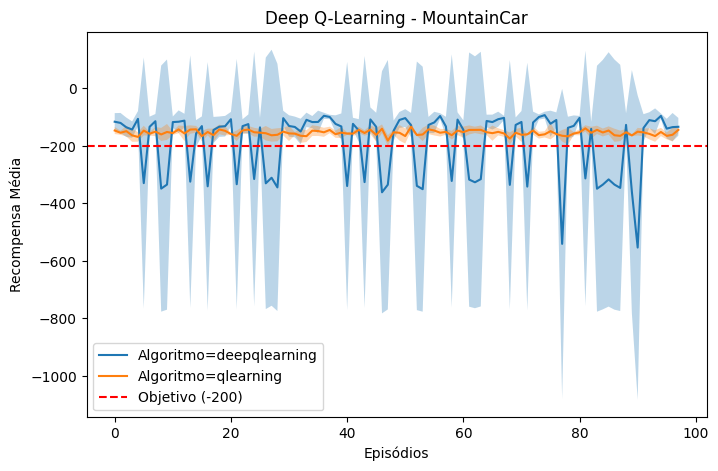

In [59]:
# Criar figura
plt.figure(figsize=(8, 5))

results_alg = {
    'deepqlearning': (np.mean(all_rewards_deepqlearning, axis=0), np.std(all_rewards_deepqlearning, axis=0)),
    'qlearning': (np.mean(all_rewards_qlearning, axis=0), np.std(all_rewards_qlearning, axis=0))
    
}

for alg in ['deepqlearning', 'qlearning']:#, 'sarsa']:
    rewards_alg_mean, rewards_alg_std = results_alg[alg]
    rewards_alg_mean = rewards_alg_mean[2:]
    rewards_alg_std = rewards_alg_std[2:]
    x_values = np.array(range(len(rewards_alg_mean))) 
    sns.lineplot(x=x_values, y=rewards_alg_mean, label="Algoritmo=" + str(alg))
    plt.fill_between(x_values, rewards_alg_mean - rewards_alg_std, rewards_alg_mean + rewards_alg_std, alpha=0.3)
    # Traçar uma reta vermelha horizontal no valor de -200
plt.axhline(y=-200, color='r', linestyle='--', label="Objetivo (-200)")

# Configurações
plt.xlabel("Episódios")
plt.ylabel("Recompensa Média")
plt.title(r"Deep Q-Learning - " + f"{env.env.env.spec.name}")
plt.legend()
plt.show()

## Atividade

Para o trabalho presente, alguns critérios foram estabelecidos como sugestões de investigação. Para nos situarmos melhor, vamos elencar todos os pontos respondendo as perguntas:

1. Treine o agente usando Q-Learning para o ambiente MountainCar usando os melhores hiperparâmetros encontrados na atividade anterior.

> R: O agente foi treinado com os hiperparâmetros $\alpha = 0.1$, $\gamma = 0.99$, $\epsilon = 1.0$, $\epsilon_{min} = 0.01$ e $\epsilon_{decay} = 0.999$.

2. Execute o treinamento $N$ vezes onde este $N$ precisa ser maior ou igual a 5.

> R: O treinamento foi executado 5 vezes.

3. Colete todos os dados para criar a curva de aprendizado.

> R: Os dados das curvas de aprendizado foram coletados e plotados nos gráficos anteriores.

4. Armazene os pesos da Q-table.

> R: Os pesos da Q-table foram armazenados no diretório `saved_models/model_qlearning_MountainCar.npy`.


5. Implemente o Deep Q-Learning para o ambiente MountainCar.

> R: O Deep Q-Learning foi implementado e treinado para o ambiente MountainCar. Os modelos utilizados estão no arquivo `models.py`.	

6. Execute o treinamento $N$ vezes onde este $N$ precisa ser maior ou igual a 5.

> R: O treinamento foi executado 5 vezes.

7. Encontre os melhores hiperparâmetros para o Deep Q-Learning.

> R: Encotramos os melhores hiperparâmetros para o Deep Q-Learning, que são $\alpha = 4-e4$, $\gamma = 0.99$, $\epsilon = 1.0$, $\epsilon_{min} = 0.01$ e $\epsilon_{decay} = 0.999$. Para conseguir desempenhos mais precisos e rápidos, será necessário um ajuste fino dos hiperparâmetros, o que pode tornar a procura bastante custosa.

8. Colete todos os dados para criar a curva de aprendizado.

> R: Os dados das curvas de aprendizado foram coletados e plotados nos gráficos anteriores.

9. Armazene os pesos da rede neural.

> R: Os pesos da rede neural foram armazenados no diretório `saved_models/model_deepqlearning_MountainCar.pth`.

10. Compare os resultados obtidos com o Q-Learning e o Deep Q-Learning usando um plot. Tente deixar claro no plot qual a meta de recompensa acumulada para o ambiente ``MountainCar``.

> R: O plot comparativo foi feito e está disponível no gráfico acima. A meta de recompensa acumulada para o ambiente MountainCar é -200 e está registrada na linha vermelha pontilhada.

11. Crie outro gráfico que mostra o desempenho de ambos os agentes durante o processo de inferência, ou seja, quando o agente está atuando sem treinamento.

> R: O gráfico de desempenho de ambos os agentes durante o processo de inferência foi criado e está disponível no gráfico acima.

12. (Extra) Gráfico de desempenho durante o treinamento.

> R: Vale ressaltar também o gráfico de treinamento. Nele é possível enxergar o desempenho de ambos os agentes durante o treinamento.